In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cv2
import os
import numpy as np
import glob
from PIL import Image

In [ ]:
def transform_image(img, skt, ang_range, shear_range, trans_range):
    '''
    This function transforms images to generate new images.
    The function takes in following arguments,
    1- Image
    2- ang_range: Range of angles for rotation
    3- shear_range: Range of values to apply affine transform to
    4- trans_range: Range of values to apply translations over.

    A Random uniform distribution is used to generate different parameters for transformation

    '''
    # Rotation

    ang_rot = np.random.uniform(ang_range)-ang_range/2
    rows,cols,ch = img.shape
    Rot_M = cv2.getRotationMatrix2D((cols/2,rows/2),ang_rot,1)

    # Translation
    tr_x = trans_range*np.random.uniform()-trans_range/2
    tr_y = trans_range*np.random.uniform()-trans_range/2
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])

    # Shear
    pts1 = np.float32([[5,5],[20,5],[5,20]])

    pt1 = 5+shear_range*np.random.uniform()-shear_range/2
    pt2 = 20+shear_range*np.random.uniform()-shear_range/2

    pts2 = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])

    shear_M = cv2.getAffineTransform(pts1,pts2)

    # Border
    idx = 0
    border_img = tuple([int(img[idx][0][0]), int(img[idx][0][1]), int(img[idx][0][2])])
    border_skt = tuple([int(skt[0][0][0]), int(skt[0][0][1]), int(skt[0][0][2])])

    img = cv2.warpAffine(img,Rot_M,(cols,rows), borderValue=border_img)
    img = cv2.warpAffine(img,Trans_M,(cols,rows), borderValue=border_img)
    img = cv2.warpAffine(img,shear_M,(cols,rows), borderValue=border_img)

    skt = cv2.warpAffine(skt,Rot_M,(cols,rows), borderValue=border_skt)
    skt = cv2.warpAffine(skt,Trans_M,(cols,rows), borderValue=border_skt)
    skt = cv2.warpAffine(skt,shear_M,(cols,rows), borderValue=border_skt)

    return img, skt

In [ ]:
# sketch_dir = '/content/gdrive/MyDrive/F-to-S/Dataset/New_Augmented_sketch/'
# photo_dir = '/content/gdrive/MyDrive/F-to-S/Dataset/New_Augmented_photo/'

# if not os.path.exists(sketch_dir):
#     os.mkdir(sketch_dir)

# if not os.path.exists(photo_dir):
#     os.mkdir(photo_dir)

# p_filenames = glob.glob('/content/gdrive/MyDrive/F-to-S/Dataset/Training photo/*')
# s_filenames = glob.glob('/content/gdrive/MyDrive/F-to-S/Dataset/Training sketch/*')

# counter = 0
# for i in range(len(p_filenames)):
#     im = cv2.imread(p_filenames[i])
#     sk = cv2.imread(s_filenames[i])

#     for j in range(200):
#         img, skt = transform_image(im, sk, 40, 10, 10)

#         cv2.imwrite(photo_dir + str(counter) + '.jpg', img)
#         cv2.imwrite(sketch_dir + str(counter) + '.jpg', skt)

#         counter += 1

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!git clone https://www.github.com/keras-team/keras-contrib.git

Cloning into 'keras-contrib'...
remote: Enumerating objects: 3634, done.
remote: Total 3634 (delta 0), reused 0 (delta 0), pack-reused 3634
Receiving objects: 100% (3634/3634), 861.24 KiB | 3.12 MiB/s, done.
Resolving deltas: 100% (2330/2330), done.


In [ ]:
%cd keras-contrib
!python setup.py install

/content/keras-contrib
running install
/usr/local/lib/python3.10/dist-packages/setuptools/_distutils/cmd.py:66: SetuptoolsDeprecationWarning: setup.py install is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` directly.
        Instead, use pypa/build, pypa/installer, pypa/build or
        other standards-based tools.

        See https://blog.ganssle.io/articles/2021/10/setup-py-deprecated.html for details.
        ********************************************************************************

!!
  self.initialize_options()
/usr/local/lib/python3.10/dist-packages/setuptools/_distutils/cmd.py:66: EasyInstallDeprecationWarning: easy_install command is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` and ``easy_install``.
        Instead, use pypa/build, pypa/installer, pypa/build or
        

In [ ]:
import keras_contrib

In [ ]:
!pip install natsort

In [ ]:
from __future__ import print_function, division

from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate, BatchNormalization, Activation, ZeroPadding2D
# from keras.layers.advanced_activations import LeakyReLU
from tensorflow.keras.layers import LeakyReLU
# from keras.layers.convolutional import UpSampling2D, Conv2D
from tensorflow.keras.layers import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam

from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img

#from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import numpy as np
import datetime
import natsort
import scipy
import sys
import os
import cv2

In [ ]:
from random import shuffle
import natsort
import numpy as np
import datetime
import matplotlib.pyplot as plt
import scipy
import sys
import os
import cv2

In [ ]:
def load_filename(path):
    dirFiles = os.listdir(path)
    for i, file in enumerate(dirFiles):
        dirFiles[i] = path + file
    return natsort.natsorted(dirFiles ,reverse=False)

# load all images in a directory into memory
def load_images(list_path, size=(256, 256)):
    img_list = list()
    # enumerate filenames in directory, assume all are images
    for filename in list_path:
        # load and resize the image
        pixels = load_img(filename, target_size=size)
        # convert to numpy array
        pixels = img_to_array(pixels)
        pixels = (pixels - 127.5) / 127.5
        img_list.append(pixels)
    return np.asarray(img_list)

In [ ]:
# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
    # unpack dataset
    trainA, trainB = dataset

    # choose random instances
    ix = np.random.randint(0, trainA.shape[0], n_samples)

    # retrieve selected images
    X1, X2 = trainA[ix], trainB[ix]

    # generate 'real' class labels (1)
    y = np.ones((n_samples, patch_shape, patch_shape, 1))

    return [X1, X2], y

# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, samples, patch_shape):
    # generate fake instance
    X = g_model.predict(samples)

    # create 'fake' class labels (0)
    y = np.zeros((len(X), patch_shape, patch_shape, 1))

    return X, y

In [ ]:
# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, d_model, dataset, target_dir='', n_samples=3):
    if target_dir and not os.path.exists(target_dir):
        os.mkdir(target_dir)
    # select a sample of input images
    [X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
    # generate a batch of fake samples
    X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
    # scale all pixels from [-1,1] to [0,1]
    X_realA = (X_realA + 1) / 2.0
    X_realB = (X_realB + 1) / 2.0
    X_fakeB = (X_fakeB + 1) / 2.0
    # plot real source images
    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + i)
        plt.axis('off')
        plt.imshow(X_realA[i])
    # plot generated target image
    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + n_samples + i)
        plt.axis('off')
        plt.imshow(X_fakeB[i])
    # plot real target image
    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + n_samples*2 + i)
        plt.axis('off')
        plt.imshow(X_realB[i])
    # save plot to file
    filename1 = 'plot_%06d.png' % (step+1)
    plt.savefig(target_dir + filename1)
    plt.close()
    # save the generator model
    g_model.save(target_dir + 'g_model.h5')

    # save the discriminator model
    d_model.save(target_dir + 'd_model.h5')

    print('>Saved: %s and %s' % (filename1, 'g_model & d_model'))


In [ ]:
def generator(img_shape):
    def conv2d(layer_in, n_filter, norm=True):
        d = Conv2D(n_filter, kernel_size=4, strides=2, padding='same')(layer_in)
        d = LeakyReLU(0.2)(d)
        if norm:
            d = InstanceNormalization()(d)
        return d

    def deconv2d(layer_in, skip_in, n_filter, dropout=0.5):
        d = UpSampling2D(size=2)(layer_in)
        d = Conv2D(n_filter, kernel_size=4, strides=1, padding='same', activation='relu')(d)
        if dropout:
            d = Dropout(dropout)(d)
        d = InstanceNormalization()(d)
        d = Concatenate()([d, skip_in])
        return d

    # Input Layer
    in_img = Input(shape=img_shape)

    # Downsampling
    d1 = conv2d(in_img, 64, norm=False)
    d2 = conv2d(d1, 128)
    d3 = conv2d(d2, 256)
    d4 = conv2d(d3, 512)
    d5 = conv2d(d4, 512)
    d6 = conv2d(d5, 512)
    d7 = conv2d(d6, 512)

    # Upsampling
    u1 = deconv2d(d7, d6, 512)
    u2 = deconv2d(u1, d5, 512)
    u3 = deconv2d(u2, d4, 512)
    u4 = deconv2d(u3, d3, 256, dropout=0)
    u5 = deconv2d(u4, d2, 128, dropout=0)
    u6 = deconv2d(u5, d1, 64, dropout=0)
    u7 = UpSampling2D(size=2)(u6)

    out_img = Conv2D(3, kernel_size=4, strides=1, padding='same', activation='tanh')(u7)

    return Model(in_img, out_img, name='generator')

In [ ]:
def discriminator(img_shape):
    def d_layer(layer_in, n_filter, norm=True):
        d = Conv2D(n_filter, kernel_size=4, strides=2, padding='same')(layer_in)
        d = LeakyReLU(0.2)(d)
        if norm:
            d = InstanceNormalization()(d)
        return d

    in_src_img = Input(shape=img_shape)
    in_target_img = Input(shape=img_shape)

    merged = Concatenate()([in_src_img, in_target_img])

    d1 = d_layer(merged, 64, norm=False)
    d2 = d_layer(d1, 128)
    d3 = d_layer(d1, 256)
    d4 = d_layer(d1, 512)

    out = Conv2D(1, kernel_size=4, strides=1, padding='same')(d4)

    return Model([in_src_img, in_target_img], out, name='discriminator')

In [ ]:
def GAN(g_model, d_model, img_shape):
    d_model.trainable = False
    in_img = Input(shape=img_shape)
    gen_out = g_model(in_img)
    dis_out = d_model([in_img, gen_out])
    model = Model(in_img, [dis_out, gen_out], name='GAN')
    return model

In [ ]:
def train(d_model, g_model, gan_model, data, target_dir, n_epochs=100, n_batch=16):


    if any(element is None for element in data):
      raise ValueError("Data elements cannot be None. Check data loading process.")


    # determine the output square shape of the discriminator
    n_patch = d_model.output_shape[1]

    blue_photo = data[0]
    blue_sketch = data[1]
    # print(type(blue_photo), type(blue_sketch))

    for i in range(n_epochs):
        print(' ========== Epoch', i+1, '========== ')

        print("check 1")
        #print(blue_sketch)
        #x = shuffle([1,2,3,4,5,6],2)
        #print(x)
        shuffle(blue_photo)
        shuffle(blue_sketch)

        print("check 1.5")
        for j in range(int(len(blue_photo)/n_batch)):

            start = int(j*n_batch)
            end = int(min(len(blue_photo), (j*n_batch)+n_batch))

            print("check 2")
            dataset = [load_images(blue_photo[start:end]), load_images(blue_sketch[start:end])]

            print("check 3")
            # select a batch of real samples
            [X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)

            print("check 4")
            # generate a batch of fake samples
            X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)

            print("check 5")
            # update discriminator for real samples
            d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)

            print("check 6")
            # update discriminator for generated samples
            d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)

            print("check 7")

            d_loss = 0.5 * np.add(d_loss1, d_loss2)

            print("check 8", gan_model.train_on_batch(X_realA, [y_real, X_realB]))

            # update the generator
            g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])

            print("check 9")

            # summarize performance
            print('Batch : %d, D Loss : %.3f | G Loss : %.3f' % (j+1, d_loss, g_loss))

            print("check 10")
        # summarize model performance
#         if (i+1) % 10 == 0:
        summarize_performance(i, g_model, d_model, dataset, target_dir)

In [ ]:
import tensorflow as tf
import keras.backend as K
from keras.losses import mean_absolute_error

def pixel_loss(y_true, y_pred):
    return K.mean(K.abs(y_true - y_pred))

def contextual_loss (y_true, y_pred):
    a = tf.image.rgb_to_grayscale(tf.slice(
                                y_pred,
                                [0,0,0,0],
                                [16, 256, 256, 3]))

    b = tf.image.rgb_to_grayscale(tf.slice(
                                y_true,
                                [0,0,0,0],
                                [16, 256, 256, 3]))

    y_pred = tf.divide(tf.add(tf.reshape(a, [tf.shape(a)[0], -1]), 1), 2)
    y_true = tf.divide(tf.add(tf.reshape(b, [tf.shape(b)[0], -1]), 1), 2)

#     tf.assert_rank(y_true,2)
#     tf.assert_rank(y_pred,2)

    p_shape = tf.shape(y_true)
    q_shape = tf.shape(y_pred)
#     tf.assert_equal(p_shape, q_shape)

    # normalize sum to 1
    p_ = tf.divide(y_true, tf.tile(tf.expand_dims(tf.reduce_sum(y_true, axis=1), 1), [1,p_shape[1]]))
    q_ = tf.divide(y_pred, tf.tile(tf.expand_dims(tf.reduce_sum(y_pred, axis=1), 1), [1,p_shape[1]]))

    return tf.reduce_sum(tf.multiply(p_, tf.math.log(tf.divide(p_, q_))), axis=1)

def total_loss (y_true, y_pred):

    px_loss = pixel_loss(y_true, y_pred)

    ctx_loss = contextual_loss(y_true, y_pred)

    return (0.2 * px_loss) + (0.8 * ctx_loss)


In [ ]:
# # dataset path
# b_photo_path = '/content/gdrive/MyDrive/F-to-S/Dataset/Augmented_photo'
# b_sketch_path = '/content/gdrive/MyDrive/F-to-S/Dataset/Augmented_sketch'

# blue_photo = load_filenames(b_photo_path)
# blue_sketch = load_filenames(b_sketch_path)

In [ ]:
!pip install natsort

In [ ]:
import natsort

def load_filenames(directory):
    dir_files = os.listdir(directory)
    for i, file in enumerate(dir_files):
        dir_files[i] = os.path.join(directory, file)
    return natsort.natsorted(dir_files, reverse=False)

In [ ]:
# dataset path
b_photo_path = '/content/gdrive/MyDrive/S_to_F/Augmented_photo/Augmented_photo'
b_sketch_path = '/content/gdrive/MyDrive/S_to_F/Augmented_photo/Augmented_sketch'

blue_photo = load_filenames(b_photo_path)
blue_sketch = load_filenames(b_sketch_path)

In [ ]:
# img = cv2.imread(blue_photo[1102])
# if img is not None:
#     # Perform operations on the image
#     plt.imshow(cv2.cvtColor(cv2.imread(blue_photo[1102]).astype('uint8'), cv2.COLOR_BGR2RGB))
# else:
#     print("Failed to load image:", blue_photo[1102])


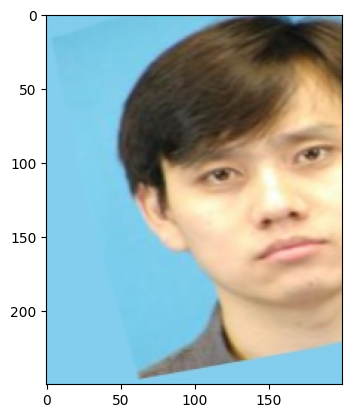

In [ ]:
plt.imshow(cv2.cvtColor(cv2.imread(blue_photo[1105]).astype('uint8'), cv2.COLOR_BGR2RGB))

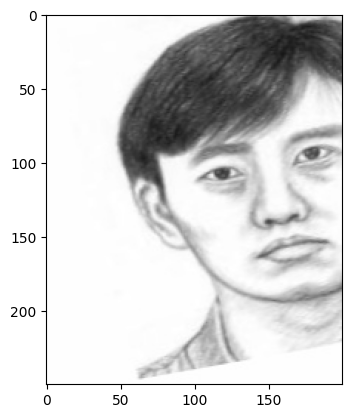

In [ ]:
plt.imshow(cv2.cvtColor(cv2.imread(blue_sketch[1105]).astype('uint8'), cv2.COLOR_BGR2RGB))

In [ ]:
img_shape = (256, 256, 3)

d_model = discriminator(img_shape)

g_model = generator(img_shape)

gan_model = GAN(g_model, d_model, img_shape)

In [ ]:
# gan_model.summary()

In [ ]:
opt = Adam(lr=2e-4, beta_1=0.5)

d_model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
gan_model.compile(loss=['binary_crossentropy', total_loss], optimizer=opt, loss_weights=[1,100])

In [ ]:
import tensorflow as tf

In [ ]:
def flatten_metrics_in_order(logs, metrics_names):
    if logs is not None:
        results = []
        for name in metrics_names:
            if name in logs:
                results.append(logs[name])
        for key in sorted(logs.keys()):
            if key not in metrics_names:
                results.append(logs[key])
        return results
    else:
        return []



In [ ]:
os.mkdir('/content/Models')

In [ ]:
os.mkdir('/content/Models/Pixel[02]_Context[08]/')

In [ ]:
# os.mkdir('/content/gdrive/MyDrive/Models/')

In [ ]:
from keras.preprocessing.image import load_img, img_to_array

In [ ]:
# from PIL import Image
# import numpy as np

# def load_image(file_path, target_size):
#     img = Image.open(file_path)
#     img = img.resize(target_size)
#     return np.array(img)

# # Example usage:
# image = load_image("path_to_image.jpg", (width, height))



In [ ]:
train(d_model, g_model, gan_model, [blue_sketch, blue_photo], '/content/gdrive/MyDrive/Models/', n_epochs = 8, n_batch=16)


 ========== Epoch 1 ========== 
check 1
check 1.5
check 2
check 3
check 4
1/1 [==============================] - 8s 8s/step
check 5
check 6
check 7
check 8 [26.563493728637695, 3.130582809448242, 0.23432910442352295]
check 9
Batch : 1, D Loss : 3.295 | G Loss : 24.910
check 10
check 2
check 3
check 4
1/1 [==============================] - 0s 31ms/step
check 5
check 6
check 7
check 8 [19.838850021362305, 3.4195995330810547, 0.16419249773025513]
check 9
Batch : 2, D Loss : 1.435 | G Loss : 17.731
check 10
check 2
check 3
check 4
1/1 [==============================] - 0s 32ms/step
check 5
check 6
check 7
check 8 [23.641265869140625, 3.486772060394287, 0.20154494047164917]
check 9
Batch : 3, D Loss : 1.482 | G Loss : 23.508
check 10
check 2
check 3
check 4
1/1 [==============================] - 0s 33ms/step
check 5
check 6
check 7
check 8 [38.23225021362305, 2.8157827854156494, 0.35416465997695923]
check 9
Batch : 4, D Loss : 2.823 | G Loss : 18.928
check 10
check 2
check 3
check 4
1/1 [==

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


>Saved: plot_000001.png and g_model & d_model
 ========== Epoch 2 ========== 
check 1
check 1.5
check 2
check 3
check 4
1/1 [==============================] - 0s 28ms/step
check 5
check 6
check 7
check 8 [18.061918258666992, 3.345897912979126, 0.14716020226478577]
check 9
Batch : 1, D Loss : 1.739 | G Loss : 17.722
check 10
check 2
check 3
check 4
1/1 [==============================] - 0s 26ms/step
check 5
check 6
check 7
check 8 [20.61988639831543, 3.8429551124572754, 0.16776931285858154]
check 9
Batch : 2, D Loss : 1.861 | G Loss : 20.386
check 10
check 2
check 3
check 4
1/1 [==============================] - 0s 50ms/step
check 5
check 6
check 7
check 8 [17.54598617553711, 2.980710983276367, 0.14565274119377136]
check 9
Batch : 3, D Loss : 1.541 | G Loss : 17.517
check 10
check 2
check 3
check 4
1/1 [==============================] - 0s 39ms/step
check 5
check 6
check 7
check 8 [16.069412231445312, 3.2076897621154785, 0.12861722707748413]
check 9
Batch : 4, D Loss : 1.698 | G Loss : 

>Saved: plot_000002.png and g_model & d_model
 ========== Epoch 3 ========== 
check 1
check 1.5
check 2
check 3
check 4
1/1 [==============================] - 0s 59ms/step
check 5
check 6
check 7
check 8 [14.624350547790527, 2.9859933853149414, 0.11638356745243073]
check 9
Batch : 1, D Loss : 1.826 | G Loss : 14.316
check 10
check 2
check 3
check 4
1/1 [==============================] - 0s 30ms/step
check 5
check 6
check 7
check 8 [14.598621368408203, 3.2835047245025635, 0.1131511703133583]
check 9
Batch : 2, D Loss : 2.057 | G Loss : 14.336
check 10
check 2
check 3
check 4
1/1 [==============================] - 0s 36ms/step
check 5
check 6
check 7
check 8 [14.200065612792969, 3.3787107467651367, 0.10821355134248734]
check 9
Batch : 3, D Loss : 2.356 | G Loss : 13.893
check 10
check 2
check 3
check 4
1/1 [==============================] - 0s 28ms/step
check 5
check 6
check 7
check 8 [14.3313570022583, 3.2346649169921875, 0.11096692085266113]
check 9
Batch : 4, D Loss : 2.076 | G Loss :

In [ ]:
from skimage.metrics import structural_similarity
import numpy as np
import natsort
import os
import cv2

In [ ]:
def load_filename(path):
    dirFiles = os.listdir(path)
    for i, file in enumerate(dirFiles):
        dirFiles[i] = path + file
    return natsort.natsorted(dirFiles ,reverse=False)

def load_images(list_path):
    img_list = list()
    for filename in list_path:
        pixels = cv2.imread(filename)
        img_list.append(pixels)
    return np.asarray(img_list)

In [ ]:
def compute_l2(imgs1, imgs2):
    l2_scores = []
    for i in range(len(imgs1)):
        score = (np.square(imgs1[i] - imgs2[i])).mean()
        l2_scores.append(score)
    return np.mean(l2_scores)

def compute_ssim(imgs1, imgs2):
    ssim_scores = []
    for i in range(len(imgs1)):
        grayA = cv2.cvtColor(imgs1[i], cv2.COLOR_BGR2GRAY)
        grayB = cv2.cvtColor(imgs2[i], cv2.COLOR_BGR2GRAY)
        (score, diff) = structural_similarity(grayA, grayB, full=True)
        ssim_scores.append(score)
    return np.mean(score)

In [ ]:
imgs1 = load_images(load_filename("/content/gdrive/MyDrive/CUHK_data/CUHK_testing_cropped_photos/"))
imgs2 = load_images(load_filename("/content/gdrive/MyDrive/S_to_F/generated_images/"))

l2 = compute_l2(imgs1, imgs2)
ssim = compute_ssim(imgs1, imgs2)

print("Pixel loss weight : 0.2 - Contextual loss weight : 0.8 => L2-norm: " + str(l2) + " :: SSIM: " + str(ssim))


Pixel loss weight : 0.2 - Contextual loss weight : 0.8 => L2-norm: 93.84704053333334 :: SSIM: 0.7185988814793303


In [ ]:
from skimage.metrics import structural_similarity as ssim
import numpy as np
import natsort
import os
import cv2

def load_filename(path):
    dirFiles = os.listdir(path)
    for i, file in enumerate(dirFiles):
        dirFiles[i] = path + file
    return natsort.natsorted(dirFiles, reverse=False)

def load_images(list_path):
    img_list = list()
    for filename in list_path:
        pixels = cv2.imread(filename)
        img_list.append(pixels)
    return np.asarray(img_list)

def compute_msssim(imgs1, imgs2):
    msssim_scores = []
    for i in range(len(imgs1)):
        grayA = cv2.cvtColor(imgs1[i], cv2.COLOR_BGR2GRAY)
        grayB = cv2.cvtColor(imgs2[i], cv2.COLOR_BGR2GRAY)
        msssim_score = ssim(grayA, grayB, multichannel=False)
        msssim_scores.append(msssim_score)
    return np.mean(msssim_scores)

imgs1 = load_images(load_filename("/content/gdrive/MyDrive/CUHK_data/CUHK_testing_cropped_photos/"))
imgs2 = load_images(load_filename("/content/gdrive/MyDrive/S_to_F/generated_images/"))

msssim = compute_msssim(imgs1, imgs2)

print("MS-SSIM:", msssim)


<ipython-input-2-835a61e08a5e>:25: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  msssim_score = ssim(grayA, grayB, multichannel=False)


MS-SSIM: 0.6651578659983888


In [ ]:
# from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
# from keras.preprocessing.image import img_to_array
# from keras.preprocessing.image import load_img
# from keras.models import load_model
# import matplotlib.pyplot as plt
# import numpy as np
# import cv2

In [ ]:
# # Load Model
# g_model = load_model('/content/gdrive/MyDrive/Models/g_model.h5',custom_objects={'InstanceNormalization':InstanceNormalization})

# # load and resize the image
# img = load_img('/content/gdrive/MyDrive/CUHK_data/CUHK_testing_cropped_sketches/m1-001-01-sz1.jpg', target_size=(256, 256))
# target = cv2.cvtColor(cv2.imread('/content/gdrive/MyDrive/CUHK_data/CUHK_testing_cropped_photos/m1-001-01.jpg'), cv2.COLOR_BGR2RGB)

# # convert to numpy array
# img = img_to_array(img)
# norm_img = (img.copy() - 127.5) / 127.5

# g_img = g_model.predict(np.expand_dims(norm_img, 0))[0]
# g_img = g_img * 127.5 + 127.5

# img = cv2.resize(img, (200, 250))
# g_img = cv2.resize(g_img, (200, 250))

# f = plt.figure(num=None, figsize=(12, 6), dpi=80)
# ax1 = f.add_subplot(1,3, 1)
# plt.imshow(img.astype('uint8'))
# ax2 = f.add_subplot(1,3, 2)
# plt.imshow(g_img.astype('uint8'))
# ax3 = f.add_subplot(1,3, 3)
# plt.imshow(target.astype('uint8'))
# ax1.set_title('Sketch')
# ax2.set_title('Generated Image')
# ax3.set_title('Target Image')

# plt.show(block=True)